
# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See image below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or an asterisk "*". We are treating all types of marks the same, a cell either has a mark or it doesn't.

Somethings to note here:
- The graphs are not clean and contain notes and stray marks.
- The scans do not always have nice strong lines to pick out.
- The scans of the graphs are crooked and contain distortions, so the lines are slightly bent, typically near the edges.
- Some of the lines are incomplete or missing. In the image below, May 1986 has more grid cells than June 1986. And the line to the left of May 1st is incomplete.

<img  src="assets/Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-25T17:14:05-04:00

CPython 3.6.1
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
skimage 0.13.1
Git hash: 4b55a5f20fc0f058b158d2ed82f9306d2923be50
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory. The first 20 images are not relevant here.

In [2]:
%%bash

RAW_DATA='raw_data'
DIRECTORY='images'

PDF1="$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2="$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1="$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2="$DIRECTORY/Boyd_M_Bird_journal_section2"

if [ ! -d "$DIRECTORY" ]; then
    mkdir $DIRECTORY
    pdfimages -png $PDF1 $PREFIX1
    pdfimages -png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [3]:
# %matplotlib notebook
%matplotlib inline

import os
import csv
from itertools import product
from collections import namedtuple

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches, cm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import cv2

from skimage import io
from skimage import util
# from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

In [4]:
in_file = 'images/Boyd_M_Bird_journal_section1-023.png'

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Define some convenience objects

In [5]:
Crop = namedtuple('Crop', 'top bottom left right')
Offset = namedtuple('Offset', 'x y')
Point = namedtuple('Point', 'x y')

#### This is the main grid class. It holds the other classes.

In [6]:
class Grid:
    """
    Container for other classes.

    The horizontal and vertical grid lines as well as the grid cells.
    """

    def __init__(self, *, file_name=None, grid=None, crop=None):
        """Make a new gird from either an image file or another grid."""
        if file_name:
            self.image = io.imread(file_name)
            self.offset = Offset(0, 0)
        elif grid:
            self.image = grid.image
            self.offset = grid.offset
            if crop:
                self.image = util.crop(self.image, ((crop.top, crop.bottom),
                                                    (crop.left, crop.right)))
                self.offset = Offset(
                    x=self.offset.x + crop.left, y=self.offset.y + crop.top)

        self.edges = util.invert(self.image)

        self.horiz = Horizontal(self.edges)
        self.vert = Vertical(self.edges)

        self.cells = []
        self.row_labels = []
        self.col_labels = []

    @property
    def header_row(self):
        """An alias for the first row."""
        return self.cells[0]

    @property
    def shape(self):
        """Make it easy to get the image shape."""
        return self.edges.shape

    @property
    def width(self):
        """Make it easy to get the image width."""
        return self.horiz.size

    @property
    def height(self):
        """Make it easy to get the image height."""
        return self.vert.size

    def get_cells(self):
        """Build the grid cells from the grid lines."""
        self.cells = []
        for row, (top, bottom) in enumerate(
                zip(self.horiz.lines[:-1], self.horiz.lines[1:])):
            self.cells.append([])
            for (left, right) in zip(self.vert.lines[:-1],
                                     self.vert.lines[1:]):
                self.cells[row].append(Cell(self, top, bottom, left, right))

    def get_row_labels(self):
        """Get row labels for the cells."""
        self.row_labels = [row[1].is_row_label() for row in self.cells]
        for i in range(1, len(self.row_labels) - 2):
            if self.row_labels[i - 1] and self.row_labels[i + 1]:
                self.row_labels[i] = True

    def get_col_labels(self):
        """Get column labels for the cells."""
        self.col_labels = []
        for cell in self.header_row:
            self.col_labels.append(False)
            days = sum(self.col_labels)
            proper_size = cell.width > 8 and cell.height > 8
            if proper_size and days:
                self.col_labels[-1] = days < 31 and cell.is_col_label()
            elif proper_size:
                proper_shape = cell.width / cell.height < 2
                self.col_labels[-1] = proper_shape and cell.is_col_label()
        for i in range(1, len(self.col_labels) - 2):
            if self.col_labels[i - 1] and self.col_labels[i + 1]:
                self.col_labels[i] = True

#### This is the base object for working with grid lines. We use if for both vertical and horizontal grid lines.

In [7]:
def intersection(line1, line2):
    """Given two lines find their intersection."""
    (x_1, y_1), (x_2, y_2) = line1
    (x_3, y_3), (x_4, y_4) = line2
    denom = (x_1 - x_2) * (y_3 - y_4) - (y_1 - y_2) * (x_3 - x_4)
    num1 = x_1 * y_2 - y_1 * x_2
    num2 = x_3 * y_4 - y_3 * x_4
    point_x = num1 * (x_3 - x_4) - (x_1 - x_2) * num2
    point_x /= denom
    point_y = num1 * (y_3 - y_4) - (y_1 - y_2) * num2
    point_y /= denom
    return Point(int(point_x), int(point_y))

In [8]:
class GridLines:
    """The base object for both hoizontal and vertical grid lines."""

    near_horiz = np.deg2rad(np.linspace(-2.0, 2.0, num=41))
    near_vert = np.deg2rad(np.linspace(88.0, 92.0, num=41))

    # I'm not sure why this is required?!
    near_horiz, near_vert = near_vert, near_horiz

    def __init__(self, image):
        """Initialize data common to all grid lines."""
        self.image = image
        self.thetas = None
        self.angles = []
        self.dists = []
        self.lines = []
        self.threshold = 500
        self.min_distance = 40

    def find_lines(self):
        """Find the grid lines using the Hough Transform."""
        h_matrix, h_angles, h_dist = hough_line(self.image, self.thetas)

        _, self.angles, self.dists = hough_line_peaks(
            h_matrix,
            h_angles,
            h_dist,
            threshold=self.threshold,
            min_distance=self.min_distance)

    def polar2endpoints(self, theta, rho):
        """
        Convert a line given in polar coordinates to line segment end points.

        The Hough Transform returns the lines in polar form but matplotlib uses
        line segment end points.
        """
        if np.abs(theta) > np.pi / 4:
            x_0 = 0
            x_1 = self.image.shape[1]
            y_0 = int(np.round(rho / np.sin(theta)))
            y_1 = int(np.round((rho - x_1 * np.cos(theta)) / np.sin(theta)))
        else:
            y_0 = 0
            y_1 = self.image.shape[0]
            x_0 = int(np.round(rho / np.cos(theta)))
            x_1 = int(np.round((rho - y_1 * np.sin(theta)) / np.cos(theta)))

        return [x_0, y_0], [x_1, y_1]

    def add_line(self, point1, point2):
        """
        Add a line to the list of lines.

        Because of the way we use line pair for finding grid cells we need to
        keep the list of lines sorted.
        """
        self.lines.append((point1, point2))
        self.sort_lines()

    def sort_lines(self):
        """Sort lines by its distance from the origin."""
        self.lines = sorted(self.lines, key=self.sort_key)

    @staticmethod
    def sort_key(key):
        """Horizontal lines are sorted by their distance on the y-axis."""
        return key[0][1]

    def find_line_end_points(self):
        """Find, convert, and sort the grid lines."""
        self.find_lines()

        self.lines = [
            self.polar2endpoints(theta, rho)
            for (theta, rho) in zip(self.angles, self.dists)]

        self.sort_lines()

#### Given a set of near horizontal angles we can find horizontal grid lines

In [9]:
class Horizontal(GridLines):
    """Contains logic that is unique to the horizontal grid lines."""

    def __init__(self, image):
        """Build horizontal grid lines."""
        super().__init__(image)
        self.size = image.shape[1]
        self.thetas = self.near_horiz
        self.threshold = self.size * 0.4

    def find_grid_lines(self, add_top_edge=False, add_bottom_edge=False):
        """Find horizontal grid lines and add extra lines."""
        super().find_line_end_points()

        if add_top_edge:
            self.add_line([0, 0], [self.image.shape[1], 0])

        if add_bottom_edge:
            self.add_line([0, self.image.shape[0]],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(key):
        """Horizontal lines are sorted by their distance on the y-axis."""
        return key[0][1]

#### Given a set of near vertical angles we can find vertical grid lines

In [10]:
class Vertical(GridLines):
    """Contains logic that is unique to the vertical grid lines."""

    def __init__(self, image):
        """Build vertical grid lines."""
        super().__init__(image)
        self.size = image.shape[0]
        self.thetas = self.near_vert
        self.threshold = self.size * 0.25

    def find_grid_lines(self, add_left_edge=False, add_right_edge=False):
        """Find vertical grid lines and add extra lines."""
        super().find_line_end_points()

        if add_left_edge:
            self.add_line([0, 0], [0, self.image.shape[0]])

        if add_right_edge:
            self.add_line([self.image.shape[1], 0],
                          [self.image.shape[1], self.image.shape[0]])

    @staticmethod
    def sort_key(key):
        """Verical lines are sorted by their distance on the x-axis."""
        return key[0][0]

#### Given horizontal and vertical grid lines we can define a grid cell

In [11]:
class Cell:
    """Data and functions for dealing with cell contents."""

    row_label_threshold = 20
    col_label_threshold = 20
    crop = ((4, 4), (4, 4))
    forward_slashes = np.deg2rad(np.linspace(65.0, 25.0, num=161))

    def __init__(self, grid, top=None, bottom=None, left=None, right=None):
        """
        Build a cell from the 4 surrounding grid lines.

        We will also get the for corners of the cell by finding the
        intersection of the grid lines.
        """
        self.image = grid.edges
        self.top_left = intersection(top, left)
        self.bottom_left = intersection(bottom, left)
        self.top_right = intersection(top, right)
        self.bottom_right = intersection(bottom, right)
        self.width = self.top_right.x - self.top_left.x
        self.height = self.bottom_left.y - self.top_left.y
        self.offset = Offset(
            x=grid.offset.x + self.top_left.x,
            y=grid.offset.y + self.top_left.y)

    def interior(self, crop=None):
        """
        Get the interior image of the cell.

        Sometimes we will want to crop the interior to try and remove the
        surrounding grid lines. That is, we want the cell contents, not the
        grid lines.
        """
        top = max(self.top_left.y, self.top_right.y)
        bottom = self.image.shape[0] - min(self.bottom_left.y,
                                           self.bottom_right.y)
        left = max(self.top_left.x, self.bottom_left.x)
        right = self.image.shape[1] - min(self.top_right.x,
                                          self.bottom_right.x)

        inside = util.crop(self.image, ((top, bottom), (left, right)))

        if crop:
            inside = util.crop(inside, crop)

        return inside

    def is_row_label(self):
        """Determine if the cell is a row label."""
        return np.mean(self.interior(self.crop)) > self.row_label_threshold

    def is_col_label(self):
        """Determine if the cell is a column label."""
        inside = self.interior(crop=self.crop)
        lines = self.has_line()
        return bool(len(lines)) or np.mean(inside) > self.col_label_threshold

    def has_line(self, angles=None):
        """Determine if the cell has a line at any of the given angles."""
        return probabilistic_hough_line(
            self.interior(crop=self.crop),
            line_length=15,
            line_gap=2,
            theta=angles)

    def get_patch(self):
        """Get the cell patch for output."""
        width = self.top_right.x - self.top_left.x
        height = self.bottom_left.y - self.top_left.y
        offset_x = self.offset.x
        offset_y = self.offset.y
        return (offset_x, offset_y), width, height

In [12]:
full_image = Grid(file_name=in_file)

## Split the image into left-hand and right-hand sides

In [13]:
def split_image(image):
    """Split the image into left and right halves."""
    crop_right_side = int(image.width / 2) + 200
    crop_left_side = image.width - crop_right_side

    left_side = Grid(grid=image, crop=Crop(
        top=0, bottom=0, left=0, right=crop_right_side))
    right_side = Grid(grid=image, crop=Crop(
        top=0, bottom=0, left=crop_left_side, right=0))

    return left_side, right_side

In [14]:
left_side, right_side = split_image(full_image)

print(full_image.shape)
print(left_side.shape)
print(right_side.shape)

(5100, 3300)
(5100, 1450)
(5100, 1850)


## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [15]:
left_side.horiz.find_grid_lines(add_top_edge=True,
                                add_bottom_edge=True)
left_side.vert.find_grid_lines(add_left_edge=True,
                               add_right_edge=True)


#### Add a vertical grid line after the first one.

We're expecting two columns of cells on the left side of the image. The cells are rather long and typically have lots of whitespace toward the right end. We expect the 1st cell to have a row number and the 2nd cell to have the bird's species identification. We are going to look at the 2nd cell to see if there is any writing in it. To help boost the signal we are going to chop the 2nd cell at a fixed width and look at that part for writing.

In [16]:
def add_vert_line(image, *, after_this_line=None, width=200):
    """
    Add a vertical line to the grid.

    We use this for finding row labels.
    """
    left = after_this_line[0][0] + width
    point1 = [left, 0]
    point2 = [left, image.height]
    image.vert.add_line(point1, point2)

In [17]:
add_vert_line(left_side, after_this_line=left_side.vert.lines[1])

#### Look at the grid from the left side of the image

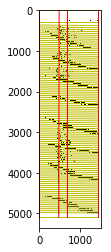

In [18]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(left_side.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

## Get grid cells in the left side of the image

We want the interior area of each cell.

In [19]:
left_side.get_cells()
left_side.get_row_labels()

print(len(left_side.cells))
print(len(left_side.cells[0]))

101
3


## Look for writing in the second cell of each row

In [20]:
left_side.get_row_labels()

has label


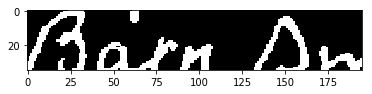

In [21]:
# @interact(row=(0, len(left_side.cells) - 1), col=(0, len(left_side.cells[0]) - 1))
def draw_row_label_interior(row, col):
    print('has label' if left_side.row_labels[row] else 'no label')
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(left_side.cells[row][col].interior(crop=Cell.crop), cmap=plt.cm.gray)

draw_row_label_interior(24, 1)

### Now split the right side into separate graphs

In [22]:
def get_month_graph_areas(left_side, right_side):
    """Chop the right side image into images for each month."""
    months = []
    for curr_row, row in enumerate(left_side.row_labels[1:], 1):

        prev_row = curr_row - 1
        if not left_side.row_labels[prev_row] and row:
            top = left_side.cells[prev_row][1].top_right.y

        if left_side.row_labels[prev_row] and not row:
            bottom = left_side.cells[curr_row][1].bottom_right.y
            months.append(
                Grid(
                    grid=right_side,
                    crop=Crop(
                        top=top,
                        bottom=right_side.height - bottom,
                        left=0,
                        right=0)))
    return months

months = get_month_graph_areas(left_side, right_side)

for month in months:
    print(month.shape)

(1503, 1850)
(938, 1850)


In [23]:
def build_month_graphs(months):
    """Find the grid for each month."""
    for month in months:
        month.horiz.find_grid_lines(add_bottom_edge=True)
        month.vert.find_grid_lines(add_left_edge=True, add_right_edge=True)

        month.get_cells()
        month.get_col_labels()

build_month_graphs(months)

for m, month in enumerate(months):
    print('month: {} rows: {}  cols: {}'.format(
        m, len(month.cells), len(month.cells[0])))
    print(list(enumerate(month.col_labels)))

NameError: name 'm' is not defined

#### Look the resulting grid

In [ ]:
@interact(mon=(0, len(months) - 1))
def show_month_grid(mon):
    month = months[mon]
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(month.image, cmap=plt.cm.gray)
    ax.set_title('Grid {}'.format(mon))

    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    plt.tight_layout()
    plt.show()

# show_month_grid(0)

### Find column labels

In [ ]:
@interact(mon=(0, len(months) - 1), col=(0, 35))
def draw_column_header_interior(mon, col):
    month = months[mon]
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[0][col]
    interior = cell.interior(crop=Cell.crop)

    mean = np.mean(interior)
    print('mean', mean)
    print('proper shape {}'.format(cell.width / cell.height < 2))
    print('proper size {}'.format(cell.width > 8 and cell.height > 8))
    print('yes' if cell.is_col_label() else '')

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = cell.has_line()
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

# draw_column_header_interior(0, 1)

### Look for forward slashes in grid cells

In [ ]:
forward_slashes = np.linspace(65.0, 25.0, num=161)
print(forward_slashes)
forward_slashes = np.deg2rad(forward_slashes)

In [ ]:
@interact(mon=(0, len(months) - 1), row=(1, 40), col=(0, 35))
def draw_cell_interior(mon, row, col):
    month = months[mon]
    row = -1 if row >= len(month.cells) else row
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[row][col]
    interior = cell.interior(Cell.crop)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = probabilistic_hough_line(
        interior, line_length=15, theta=forward_slashes)
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    print('lines', len(lines))
    print('yes' if len(lines) else '')


# draw_cell_interior(1, 18, 30)
# draw_cell_interior(1, 27, 27)

In [ ]:
@interact(mon=(0, len(months) - 1))
def show_slashes(mon):
    month = months[mon]
    for row in month.cells[1:-1]:
        for col, cell in enumerate(row):
            if month.col_labels[col]:
                print('/' if cell.has_line(forward_slashes) else '.', end=' ')
        print()
# show_slashes(0)

### Stitch image parts back together to report output

This image shows how we broke up the input image to get the monthly charts. Doing it this way reduces distortion.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(full_image.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

for month in months:
    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-g', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.show()

## Output the results

In [ ]:
file_name = os.path.basename(in_file)

base_name, _ = os.path.splitext(file_name)
csv_path = os.path.join('output', base_name + '.csv')
img_path = os.path.join('output', base_name + '_out.png')


with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    header = ['file_name', 'chart_in_file',
              'year', 'month', 'row_no', 'bird_species']
    header += [i for i in range(1, 32)]
    writer.writerow(header)

    fig, ax = plt.subplots(figsize=(10, 15.45), frameon=False)
    ax.imshow(full_image.image, cmap=plt.cm.gray)
    ax.axis('off')

    # Color in row labels
    for r, row in enumerate(left_side.cells):
        if left_side.row_labels[r]:
            nw, width, height = row[0].get_patch()
            ax.add_patch(patches.Rectangle(
                nw, width, height, alpha=0.5, facecolor='#feb209'))

    for m, month in enumerate(months):

        # Color in column labels
        for col, cell in enumerate(month.cells[0]):
            if month.col_labels[col]:
                nw, width, height = cell.get_patch()
                ax.add_patch(patches.Rectangle(
                    nw, width, height, alpha=0.5, facecolor='#feb209'))

        # Color in grid cells with slashes
        for r, cell_row in enumerate(month.cells[1:-1]):
            row = [base_name, m + 1, '', '', r + 1, '']
            csv_cells = ['' for i in range(31)]
            day = -1
            for col, cell in enumerate(cell_row):
                if month.col_labels[col]:
                    day += 1
                    if cell.has_line(forward_slashes):
                        nw, width, height = cell.get_patch()
                        ax.add_patch(patches.Rectangle(
                            nw, width, height, alpha=0.5, facecolor='#39ad48'))
                        csv_cells[day] = 1
            row += csv_cells
            writer.writerow(row)

plt.savefig(img_path, dpi=300, bbox_inches='tight')

# Failed experiments

- Try merging endpoints: Lines are pretty skew across the entire image. I tried to use interior points to make grid lines. This didn't really help things.

- Probabilistic Hough line: This may work for other parts of the image, like slashes, but it didn't help with either grid lines or row labels. It proved to be much slower and harder to tune for finding grid lines that span the entire image.

- OpenCV: This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application. Also, OpenCV is difficult to install.